In [27]:
import warnings

import matplotlib.pyplot as plt
import missingno
import numpy as np
import pandas as pd
import seaborn as sns
from fancyimpute import MICE
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import Imputer

warnings.filterwarnings("ignore")
plt.style.use("fivethirtyeight")

In [28]:
train = pd.read_csv("/home/iyed/.kaggle/competitions/titanic/train.csv")
test = pd.read_csv("/home/iyed/.kaggle/competitions/titanic/test.csv")
train.rename(str.lower, axis=1, inplace=True)
test.rename(str.lower, axis=1, inplace=True)

In [29]:
for col in ["pclass", "sex", "cabin", "embarked", "survived"]:
    train[col] = train[col].astype("category")
for col in ["pclass", "sex", "cabin", "embarked"]:
    test[col] = test[col].astype("category")

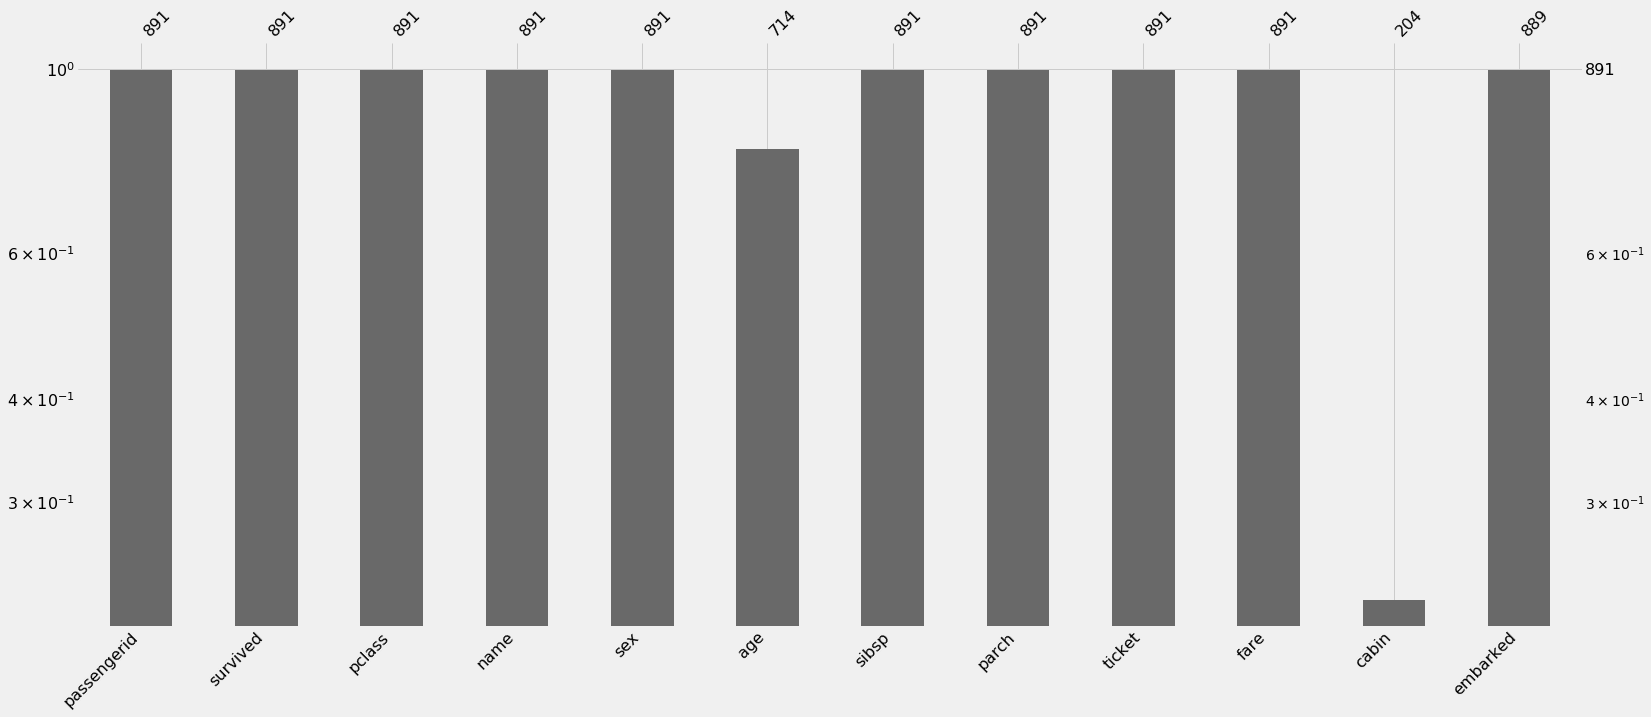

In [30]:
missingno.bar(train, log=True, sort="ascending")

### Transformers

In [31]:
# https://zablo.net/blog/post/pandas-dataframe-in-scikit-learn-feature-union
from scipy import sparse
from sklearn.externals.joblib import Parallel, delayed
from sklearn.pipeline import FeatureUnion, _fit_transform_one, _transform_one


class PandasFeatureUnion(FeatureUnion):
    def fit_transform(self, X, y=None, **fit_params):
        self._validate_transformers()
        result = Parallel(n_jobs=self.n_jobs)(
            delayed(_fit_transform_one)(trans, weight, X, y, **fit_params)
            for name, trans, weight in self._iter())

        if not result:
            # All transformers are None
            return np.zeros((X.shape[0], 0))
        Xs, transformers = zip(*result)
        self._update_transformer_list(transformers)
        if any(sparse.issparse(f) for f in Xs):
            Xs = sparse.hstack(Xs).tocsr()
        else:
            Xs = self.merge_dataframes_by_column(Xs)
        return Xs

    def merge_dataframes_by_column(self, Xs):
        return pd.concat(Xs, axis="columns", copy=False)

    def transform(self, X):
        Xs = Parallel(n_jobs=self.n_jobs)(
            delayed(_transform_one)(trans, weight, X)
            for name, trans, weight in self._iter())
        if not Xs:
            # All transformers are None
            return np.zeros((X.shape[0], 0))
        if any(sparse.issparse(f) for f in Xs):
            Xs = sparse.hstack(Xs).tocsr()
        else:
            Xs = self.merge_dataframes_by_column(Xs)
        return Xs

In [32]:
class NoFitMixin():
    def fit(self, X, y=None):
        return self


class MICEImputer(BaseEstimator, TransformerMixin, NoFitMixin):
    def transform(self, X, *args, **kwargs):
        """
            Fill a 1-D array missing values with MICE
        """
        # Should check that there is a single column
        # if not enforce it
        has_null = X.iloc[:, 0].isnull().any()  # TODO: too hakcy, improve
        if has_null:
            mice = MICE(verbose=False, *args, **kwargs)
            imputed = mice.complete(X.values.reshape(-1, 1))
            X.loc[:] = imputed
            return pd.DataFrame(X)
        else:
            return X


class ColumnSelector(BaseEstimator, TransformerMixin, NoFitMixin):
    def __init__(self, columns):
        self.columns = columns

    def transform(self, X, y=None):
        return X[self.columns]


class ColumnDummifier(BaseEstimator, TransformerMixin, NoFitMixin):
    def transform(self, X, y=None):
        return pd.get_dummies(X, sparse=True, drop_first=True)

## Explore

In [33]:
train_x = train.drop(columns=["survived"])
train_y = train.survived

In [34]:
benchmark_pipeline = Pipeline(
    [("prep",
      PandasFeatureUnion(
          [("age", make_pipeline(
              ColumnSelector(columns=["age"]), MICEImputer())),
           ("sex_dummy",
            make_pipeline(ColumnSelector(columns=["sex"]),
                          ColumnDummifier())), ("fare",
                                                make_pipeline(
                                                    ColumnSelector(["fare"]),
                                                    MICEImputer())),
           ("rest",
            make_pipeline(
                ColumnSelector(columns=["parch", "sibsp", "pclass"])))]))])

## Benchmark model

In [35]:
lr_pipeline = make_pipeline(benchmark_pipeline, LogisticRegression())

In [36]:
lr_pipeline.fit(train, train_y)

Pipeline(memory=None,
     steps=[('pipeline', Pipeline(memory=None,
     steps=[('prep', PandasFeatureUnion(n_jobs=1,
          transformer_list=[('age', Pipeline(memory=None,
     steps=[('columnselector', ColumnSelector(columns=['age'])), ('miceimputer', MICEImputer())])), ('sex_dummy', Pipeline(memory=None,
     steps=[('...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [37]:
accuracy_score(train_y, lr_pipeline.predict(train_x))

0.7991021324354658

In [38]:
validation = pd.read_excel("/home/iyed/Downloads/titanic3.xls")

In [39]:
accuracy_score(validation.survived, lr_pipeline.predict(validation))

0.7883880825057296